<a href="https://colab.research.google.com/github/ZimingY/ML-projects-notebook/blob/master/cnn_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# CNN for classification with CIFAR-10 dataset
!pip install torch

In [0]:
# downloading CIFAR-10 dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision # datasets
import torchvision.transforms as transforms # compose two set
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [39]:
# convert python image library format to pytorch tensors
# Then normalize the data by specifying a mean and standard
# deviation for each of the three channels
batch_size = 4
transform = transforms.Compose(
                               [transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5),
                                                     (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./train_data',
                                        train=True,
                                        download=True,
                                        transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./test_data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


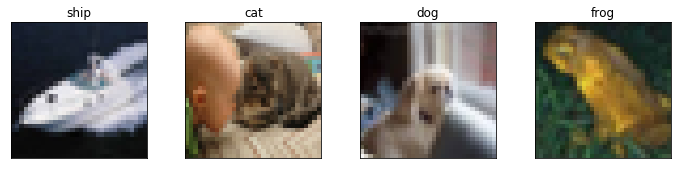

In [62]:
# take a look at the dataset

def convert_to_imshow_format(image):
	# first convert back to [0,1] range from [-1,1] range
	image = image / 2 + 0.5
	image = image.numpy()
	# convert from CHW to HWC
	# from 3x32x32 to 32x32x3
	return image.transpose(1,2,0)

dataiter = iter(trainloader)
images, labels = dataiter.next()

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
	axes[idx].imshow(convert_to_imshow_format(image))
	axes[idx].set_title(classes[labels[idx]])
	axes[idx].set_xticks([])
	axes[idx].set_yticks([])

In [61]:
image.size()

torch.Size([3, 32, 32])

Model Class

In [0]:
class MyCNN(nn.Module):
	def __init__(self):
		super().__init__()
		# 3,32,32 -> 6,28,28
		self.conv1 = nn.Conv2d(3, 6, 5)
		# 6,28,28 -> 6,14,14
		self.pool = nn.MaxPool2d(2, 2)
		# 6,14,14 -> 16,10,10
		self.conv2 = nn.Conv2d(6, 16, 5)
		# 16,10,10 -> 16,5,5 -> 120
		self.fc1 = nn.Linear(16*5*5, 120)
		self.fc2 = nn.Linear(120, 84)
		self.fc3 = nn.Linear(84, 10)

	def forward(self, x):
		x = F.relu(self.conv1(x))
		x = self.pool(x)
		x = F.relu(self.conv2(x))
		x = self.pool(x)
		x = x.view(-1, 16*5*5)
		x = F.relu(self.fc1(x))
		x = F.relu(self.fc2(x))
		x = self.fc3(x)
		x = F.softmax(x)
		return x


net = MyCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Train the network 

In [43]:
model_folder = './model/'
model_path = model_folder + 'cifar_cnn_model.pt'
epochs = 10

def valiloss(net, testdata):
	'''
	return the model accuracy on all test images
	the accuracy for each category 
	'''
	total_correct = 0
	total_images = 0
	confusion_matrix = np.zeros([10,10], int)
	with torch.no_grad():
		for data in testdata:
			images, labels = data
			outputs = net(images)
			_, pred = torch.max(outputs.data, 1)
			total_images += labels.size(0)
			total_correct += (pred==labels).sum().item()
			for i, l in enumerate(labels):
				confusion_matrix[l.item(), pred[i].item()] += 1
	return total_correct / total_images * 100, confusion_matrix


if not os.path.exists(model_folder):
	os.makedirs(model_folder)

if os.path.isfile(model_path):
	net.load_state_dict(torch.load(model_path))
	print('loading model from disk')
else:
	for epoch in range(epochs):
		running_loss = 0.0
		corrects = 0.0
		for i, data in enumerate(trainloader):
			inputs, labels = data
			optimizer.zero_grad()
			outputs = net(inputs)
			loss = criterion(outputs, labels)
			
			loss.backward()
			optimizer.step()

			running_loss += loss.item()
			_, pred = torch.max(outputs, 1)
			corrects += torch.sum(pred == labels.data)
			if i % 2000 == 1999:  # print every 2000 mini-batches
				print('[%d, %5d] training loss: %.3f' %
                     (epoch+1, i+1, running_loss / (2000*batch_size)))
				print('[%d, %5d] accuracy: %.3f' % 
                     (epoch+1, i+1, corrects / (2000*batch_size)))
				running_loss = 0.0
				corrects = 0.0
				test_acc, confusion_matrix = valiloss(net, testloader)
				print('[%d, %5d] val accuracy: %.3f' % (epoch+1, i+1, test_acc))

		torch.save(net.state_dict(), model_path)
		print('save model to disk in epoch %d' % (epoch))


loading model from disk


In [53]:
print('validation accuracy is ',test_acc )
print( '{0:10s} - {1}'.format('Category', 'Accuracy'))
for i, r in enumerate(confusion_matrix):
  print('{0:10s} - {1:.1f}'.format(classes[i], r[i]/np.sum(r)))

validation accuracy is  50.970000000000006
Category   - Accuracy
plane      - 0.8
car        - 0.6
bird       - 0.4
cat        - 0.3
deer       - 0.5
dog        - 0.5
frog       - 0.7
horse      - 0.5
ship       - 0.5
truck      - 0.3


In [54]:
confusion_matrix

array([[789,  22,  51,  15,  39,   9,  23,   3,  38,  11],
       [202, 591,  18,  14,  16,   7,  17,   5,  85,  45],
       [127,   7, 416,  57, 176,  73,  93,  21,  23,   7],
       [ 76,  16, 103, 282,  97, 229, 113,  34,  27,  23],
       [ 87,   4,  95,  36, 519,  47, 137,  55,  16,   4],
       [ 39,   3, 147, 122,  84, 472,  57,  48,  23,   5],
       [ 26,   9,  52,  57, 117,  17, 686,  14,  18,   4],
       [ 55,   7,  85,  52, 121,  97,  37, 512,  11,  23],
       [384,  33,  30,  11,  16,  21,   8,   6, 485,   6],
       [182, 227,  32,  27,  14,  25,  37,  26,  85, 345]])

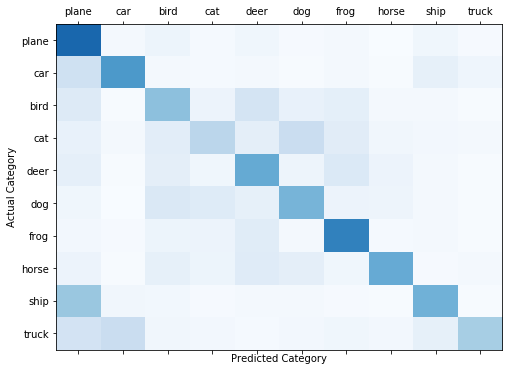

In [65]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()